In [1]:
import sys

sys.path.append("..")

import numpy as np

import tensorflow as tf

from utils import viz_utils, eeg_utils, fmri_utils, tf_config, process_utils, preprocess_data, train, losses_utils

from models import eeg_to_fmri, classifiers

from layers import fft

from sklearn import metrics

import matplotlib.pyplot as plt

tf_config.set_seed(seed=3)#02 20
tf_config.setup_tensorflow(device="GPU", memory_limit=2000)

path_labels="../../metrics/10_synth_01_style_prior_bayesian/"
view="fmri"

In [2]:
views = np.load(path_labels+"views.npy", allow_pickle=True)
y_true = np.load(path_labels+"y_true.npy")
y_pred = np.load(path_labels+"y_pred.npy")

## Load patterns

In [86]:
class Pattern:
    
    def __init__(self, values, size, voxels, instances, pvalue, lifts):
        
        self.values=values
        self.size=size
        self.voxels=voxels
        self.instances=instances
        self.pvalue=pvalue
        self.lifts=lifts
        
    def mask(self, X, low=False, resolution=None):
        if(low):
            assert not resolution is None
        else:
            resolution=X.shape[1:-1]
        
        z = np.zeros((X.shape[0],)+resolution, dtype=np.float32)
        z = np.reshape(z, (X.shape[0], resolution[0]*resolution[1]*resolution[2]))
        z[self.instances,:]=1.
        z[:,self.voxels]*=-1.
        z[np.where(z==1.)]=0.0
        z[np.where(z==-1.)]=1.0
        
        z = np.reshape(z, (X.shape[0],)+resolution)
        
        if(low):
            z_high = np.zeros(X.shape, dtype=np.float32)
            for instance in range(z.shape[0]):
                z_i=np.reshape(z[instance:instance+1], (1,)+resolution)
                z_high[instance] = np.expand_dims(fft.padded_iDCT3D(*resolution, *X.shape[1:-1])(fft.DCT3D(*resolution)(z_i)).numpy(), axis=-1)
            z=z_high
            
        return (z-np.amin(z))/(np.amax(z)-np.amin(z))
    
    def __eq__(self, other):
        return self.__hash__()==other.__hash__()
    
    def __hash__(self):
        return str(self.values)+"_"+str(self.size)+"_"+str(self.voxels)+"_"+str(self.instances)+"_"+str(self.pvalue)+"_"+str(self.lifts)        

class Bics_Patterns:
    
    def __init__(self, X, relu=None, low=True, resolution=(14,14,7)):
        self.patterns=[]
        self.delete_patterns=[]
        self.X=X
        self.relu=relu
        self.low=low
        self.resolution=resolution
        
    def add(self, pattern):
        if(type(pattern) is dict):
            raise NotImplementedError  
        elif(type(pattern) is Pattern):
            self.patterns+=[pattern]
            self.delete_patterns+=[pattern]
        else:
            print("E: Pattern structure not recognized.")
        
    def get(self, index):
        assert index < len(self.patterns)
        
        return self.patterns[index]
    
    def get_delete(self, index):
        assert index < len(self.delete_patterns)
        
        return self.delete_patterns[index]
        
    def get_best(self, delete=False):
        search_patterns=self.delete_patterns
            
        best_value=-1
        best_index=-1
        for pattern in range(len(search_patterns)):
            lifts=np.mean(self.get_delete(pattern).lifts)
            if(lifts>best_value):
                best_value=lifts
                best_index=pattern
        
        index=self.patterns.index(search_patterns[best_index])
        
        if(delete):
            del self.delete_patterns[best_index]
        
        return index
    
    def get_best_pattern(self):
        return self.patterns[self.get_best()]
    
    def apply_mask(self, index):
        pattern=self.get(index)
        return pattern.mask(self.X, low=self.low, resolution=self.resolution)
        
    def apply_mask_relu(self, index):
        pattern=self.get(index)
        return pattern.mask(self.relu, low=self.low, resolution=self.resolution)
    
    @classmethod
    def build(self, f, X, **kwargs):
        patterns=Bics_Patterns(X, **kwargs)
        
        with open(f, "r") as f:
            lines = f.readlines()
        for line in lines:
            if(not "I=" in line):
                continue
            if("too small" in line):
                continue
            if("long" in line):
                continue

            line_list=line[1:-1].split(" ")
            values=np.array(line_list[0][3:-1].split(","), dtype="float32")#I
            size=(int(line_list[1][1:-1].split(",")[0]), int(line_list[1][1:-1].split(",")[1]))
            voxels=np.array(line_list[2][3:-1].split(","), dtype="int32")
            instances=np.array(line_list[3][3:-1].split(","), dtype="int32")
            pvalue=float(line_list[4].split("=")[1])
            class_lifts=np.array([float(line_list[5].split("=")[1][1:-1]),float(line_list[6][:-1])], dtype="float32")       
            patterns.add(Pattern(values,size,voxels,instances,pvalue,class_lifts))
            
        return patterns

In [141]:
patterns=Bics_Patterns.build("../../biclusters/10/view_bics_v1.txt", views, relu=None, low=True, resolution=(14,14,7))

In [165]:
best_index=patterns.get_best(delete=True)
print(best_index)
print(patterns.get(best_index).lifts)
masked_data=patterns.apply_mask(best_index)

63
[1.3141093  0.66756755]


In [166]:
threshold=1.
indices=np.unique(np.where(masked_data>=threshold)[0])

print("Discriminates: ",np.unique(y_true[indices]))

Discriminates:  [0.]


In [167]:
while(True):
    best_index=patterns.get_best(delete=True)
    print(best_index)
    print(patterns.get(best_index).lifts)
    masked_data=patterns.apply_mask(best_index)
    threshold=1.
    indices=np.unique(np.where(masked_data>=threshold)[0])

    print("Discriminates: ",np.unique(y_true[indices]))

68
[1.3141093  0.66756755]
Discriminates:  [0.]
20
[1.3464566 0.6333333]
Discriminates:  [0.]
53
[1.3464566 0.6333333]
Discriminates:  [0.]
1
[1.3506124  0.62893516]
Discriminates:  [0.]
4
[1.3506124  0.62893516]
Discriminates:  [0.]
5
[1.3506124  0.62893516]
Discriminates:  [0.]
8
[1.3506124  0.62893516]



KeyboardInterrupt



## Visualize Biclustering Patterns 

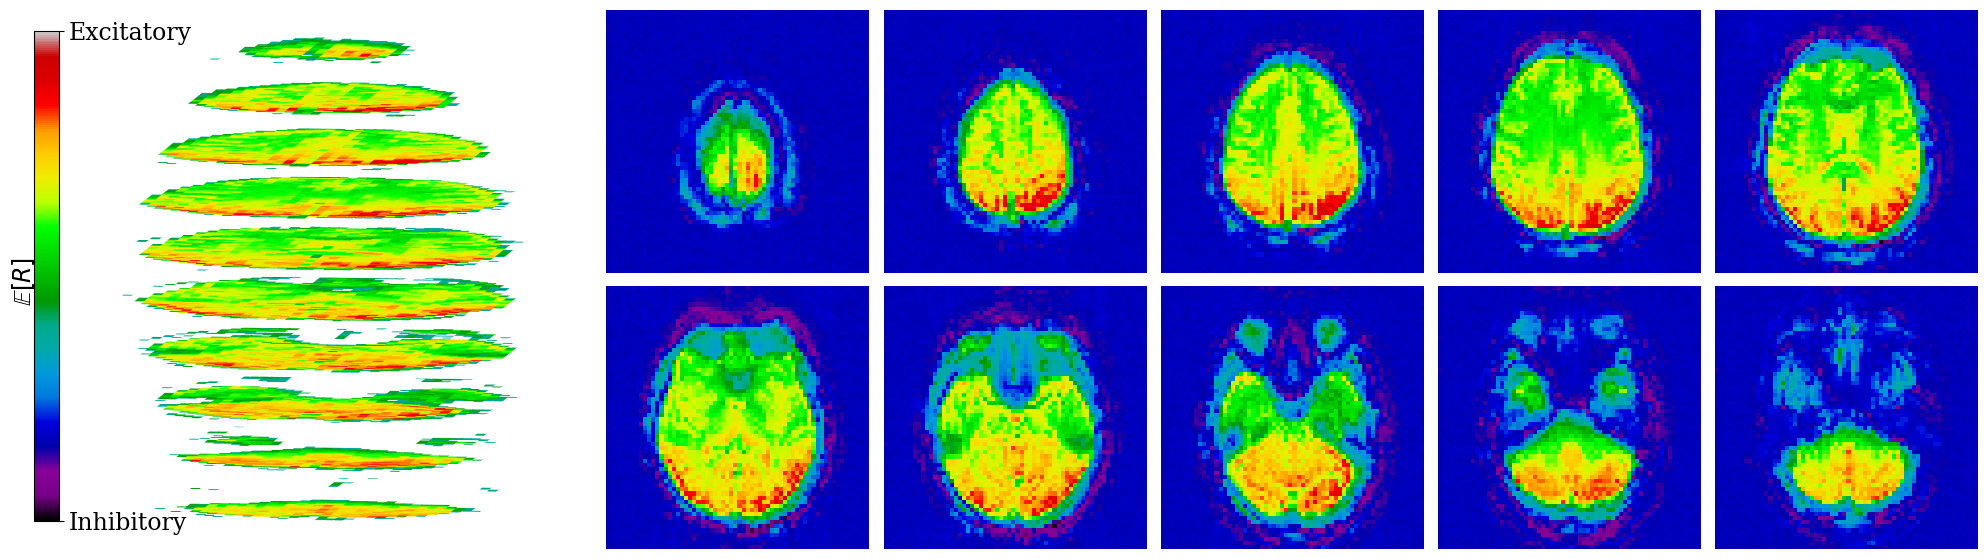

In [144]:

#21,25,29
fig = viz_utils.plot_3D_representation_projected_slices(np.mean(views[indices], axis=0),
                                                        res_img=np.mean(views[indices],axis=0),
                                                        slice_label=False,
                                                        uncertainty=True,
                                                       legend_colorbar=r"$\mathbb{E}[R]$",
                                                       save=False, save_path="/home/ist_davidcalhas/mean_fmri_explainability.pdf",
                                                       max_min_legend=["Inhibitory","Excitatory"])

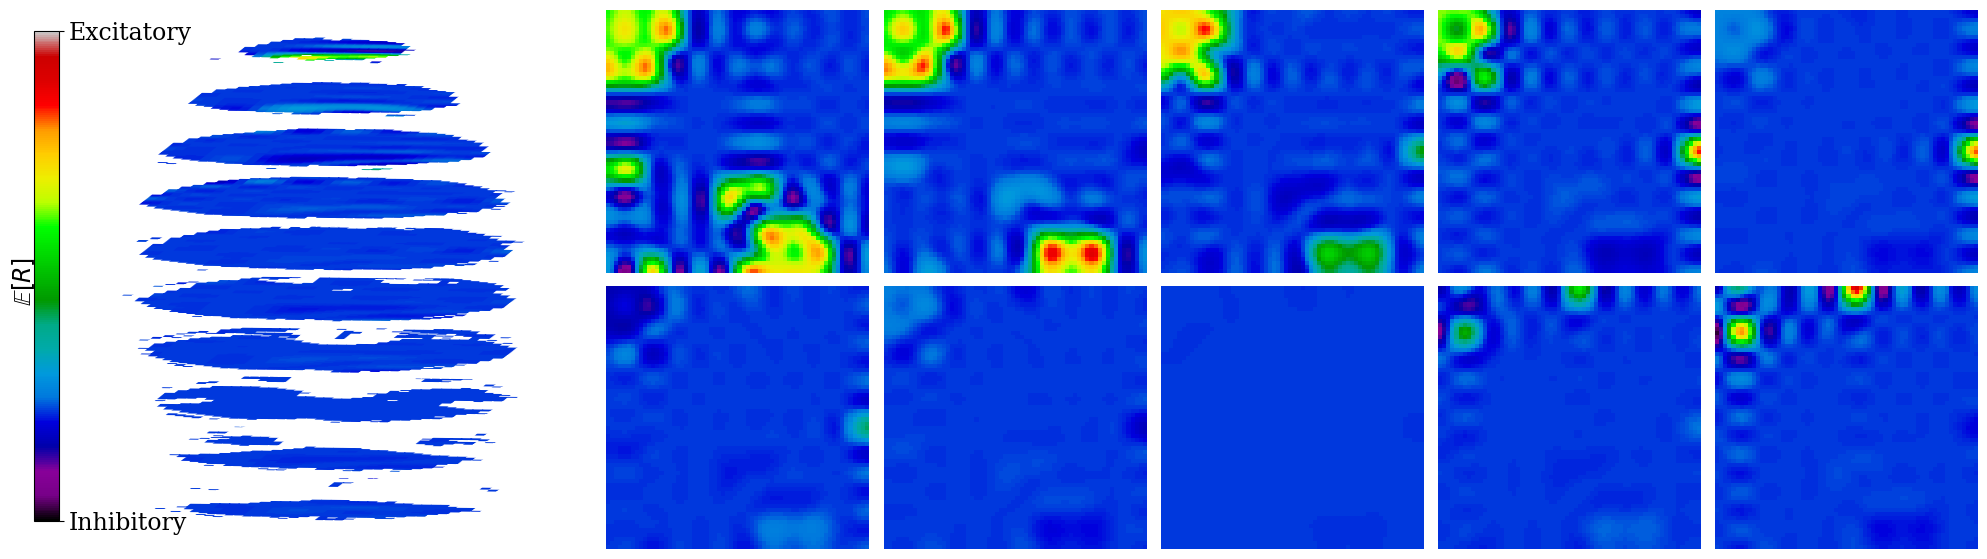

In [145]:
fig = viz_utils.plot_3D_representation_projected_slices(np.amax(masked_data[indices], axis=0),
                                                        res_img=np.mean(views[indices],axis=0),
                                                        slice_label=False,
                                                        uncertainty=True,
                                                       legend_colorbar=r"$\mathbb{E}[R]$",
                                                       save=False, save_path="/home/ist_davidcalhas/mean_fmri_explainability.pdf",
                                                       max_min_legend=["Inhibitory","Excitatory"])

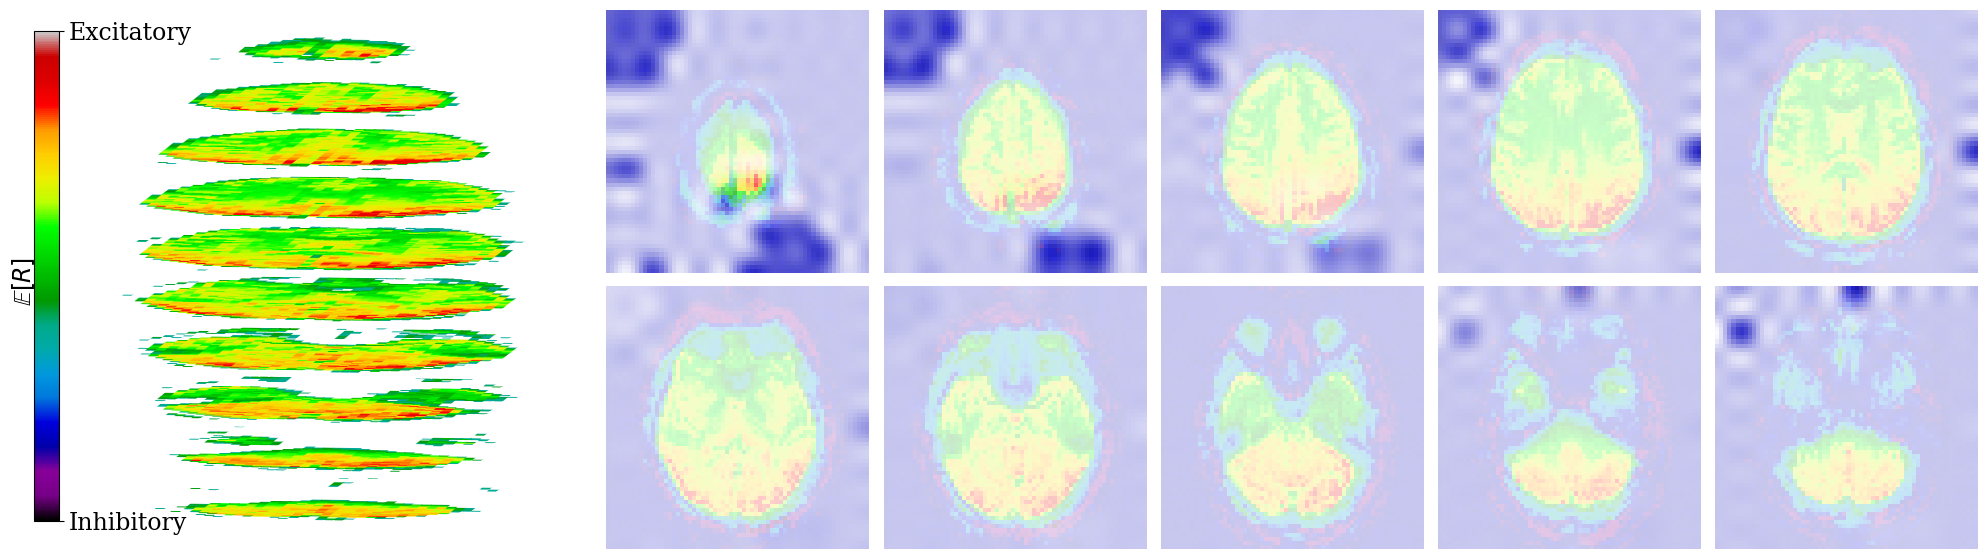

In [146]:
fig = viz_utils.plot_3D_representation_projected_slices_alpha(np.mean(views[indices], axis=0),
                                                        res_img=np.mean(views[indices],axis=0),
                                                        alpha_img=np.amax(masked_data[indices], axis=0),
                                                        slice_label=False,
                                                        uncertainty=True,
                                                       legend_colorbar=r"$\mathbb{E}[R]$",
                                                       save=False, save_path="/home/ist_davidcalhas/mean_fmri_explainability.pdf",
                                                       max_min_legend=["Inhibitory","Excitatory"])